# Load required libaries

In [ ]:
# tensorflow version
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)
# keras version
import keras
print('keras: %s' % keras.__version__)

tensorflow: 2.4.1
keras: 2.4.3


# Load Dataset and Configure Path

In [ ]:
import pandas as pd
import json
import glob
import numpy as np

In [ ]:
base_url = "/content/drive/MyDrive/Semester 4/32933 - Research Project/KTH Dataset and Code"

dataset_kth = f"{base_url}/KTH Dataset/dataset.json"
video_path_dir = f"{base_url}/KTH Images"

In [ ]:
with open(dataset_kth) as f:
  data = json.load(f)

In [ ]:
df = pd.DataFrame(data["data"])

In [ ]:
df["id"] = df.index + 1

In [ ]:
df

,action,folder_name,caption,total_images,id
0,boxing,/boxing/person01_boxing_d1_uncomp.avi,a man is practising boxing outdoor,359,1
1,boxing,/boxing/person01_boxing_d2_uncomp.avi,a man is practising boxing outdoor,389,2
2,boxing,/boxing/person01_boxing_d3_uncomp.avi,an old man boxing outdoor,464,3
3,boxing,/boxing/person02_boxing_d1_uncomp.avi,a man is practising boxing outdoor,427,4
4,boxing,/boxing/person02_boxing_d2_uncomp.avi,a man is practising boxing outdoor,459,5
...,...,...,...,...,...
593,walking,/walking/person24_walking_d4_uncomp.avi,a person is walking indoor,378,594
594,walking,/walking/person25_walking_d1_uncomp.avi,a man is walking outdoor,566,595
595,walking,/walking/person25_walking_d2_uncomp.avi,a man is walking outdoor,779,596
596,walking,/walking/person25_walking_d3_uncomp.avi,a man is walking outdoor,500,597


In [ ]:
i = 0
video = df.iloc[[i]]['folder_name'].values[0]
video

'/boxing/person01_boxing_d1_uncomp.avi'

In [ ]:
x = f"{video_path_dir}{video}"
x

'/content/drive/MyDrive/Semester 4/32933 - Research Project/KTH Dataset and Code/KTH Images/boxing/person01_boxing_d1_uncomp.avi'

In [ ]:
list_images = (glob.glob(f"{x}/*.jpg"))

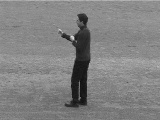

In [ ]:
from keras.preprocessing.image import load_img

image = load_img(list_images[0])
image

In [ ]:
def images_from_path(path):
  images = f"{video_path_dir}{path}"
  list_images = (glob.glob(f"{images}/*.jpg"))

  return list_images

In [ ]:
from random import randrange
print(randrange(100))

69


# Prepare Image Data (Extract Features using CNN)

In [ ]:
#Import Necessary Libraries
from os import listdir
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

In [ ]:
model = VGG16()
model.layers.pop()
model = Model(inputs=model.inputs, outputs=model.layers[-1].output)

filename = list_images[200]
image = load_img(filename, target_size=(224, 224))
# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image)
# get features
feature = model.predict(image, verbose=0)
# store feature
print(feature.shape)

553467904/553467096 [==============================] - 3s 0us/step
(1, 1000)


In [ ]:
def extract_features(df):
  model = VGG16()
  model.layers.pop()
  model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
  # print(model.summary())

  features = dict()
  for i in range(df.shape[0]):
    video_path = df.iloc[[i]]['folder_name'].values[0]
    list_images = images_from_path(video_path)
    ran = randrange(len(list_images))
    image_path = list_images[ran]

    image_id = df.iloc[[i]]['id'].values[0]

    filename = image_path
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    features[image_id] = feature
    print(f"{image_id}. {filename}")
  return features

In [ ]:
features = extract_features(df)

In [ ]:
dump(features, open(video_path_dir + 'features.pkl', 'wb'))

# Load and Clean Text Data (Captions)

In [ ]:
import string

In [ ]:
# extract descriptions for images
def load_descriptions(df):
  mapping = dict()
  for i in range(df.shape[0]):
    id = df.iloc[[i]]['id'].values[0]
    caption = df.iloc[[i]]['caption'].values[0]

    image_id, image_desc = id, caption
    if image_id not in mapping:
      mapping[image_id] = list()
    mapping[image_id].append(image_desc)
  return mapping

descriptions = load_descriptions(df)
print('Loaded: %d ' % len(descriptions))

Loaded: 598 


In [ ]:
descriptions

{1: ['a man is practising boxing outdoor'],
 2: ['a man is practising boxing outdoor'],
 3: ['an old  man boxing outdoor'],
 4: ['a man is practising boxing outdoor'],
 5: ['a man is practising boxing outdoor'],
 6: ['a man is practising boxing outdoor'],
 7: ['a man is boxing indoor'],
 8: ['a man is practising boxing outdoor'],
 9: ['a man is practising boxing outdoor'],
 10: ['a man is practising boxing outdoor'],
 11: ['a man is boxing in indoor'],
 12: ['a man is practising boxing outdoor'],
 13: ['a man is practising boxing outdoor'],
 14: ['a man is practising boxing outdoor'],
 15: ['a man is practising boxing outdoor'],
 16: ['a man is practising boxing outdoor'],
 17: ['a man is practising boxing outdoor'],
 18: ['a man is practising boxing outdoor'],
 19: ['a man is practising boxing indoor'],
 20: ['a man is practising boxing outdoor'],
 21: ['a man is practising boxing outdoor'],
 22: ['a man is practising boxing outdoor'],
 23: ['a man is practising boxing indoor'],
 24: 

In [ ]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)
 
# clean descriptions
clean_descriptions(descriptions)

In [ ]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc
 
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 22


In [ ]:
vocabulary

{'an',
 'boxing',
 'boy',
 'child',
 'clapping',
 'girl',
 'hands',
 'in',
 'indoor',
 'is',
 'jogging',
 'man',
 'old',
 'outdoor',
 'person',
 'practising',
 'running',
 'the',
 'walking',
 'waving',
 'woman',
 'young'}

In [ ]:
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc in descriptions.items():
			lines.append(str(key) + ' ' + str(desc))
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()
 
# save descriptions
save_descriptions(descriptions, video_path_dir + 'descriptions.txt')

# Develop Deep Learning Model

### Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [ ]:
train, validate, test = np.split(df.sample(frac=1, random_state=42), 
                       [int(.7*len(df)), int(.85*len(df))])

In [ ]:
test

,action,folder_name,caption,total_images,id
378,jogging,/jogging/person21_jogging_d1_uncomp.avi,a man is jogging outdoor,571,379
288,handclapping,/handclapping/person23_handclapping_d3_uncomp.avi,a man is clapping hands outdoor,481,289
418,running,/running/person06_running_d1_uncomp.avi,a man is running outdoor,275,419
162,handwaving,/handwaving/person16_handwaving_d4_uncomp.avi,a man is waving the hands indoor,455,163
391,jogging,/jogging/person24_jogging_d2_uncomp.avi,a man is jogging outdoor,637,392
...,...,...,...,...,...
71,boxing,/boxing/person19_boxing_d1_uncomp.avi,a man is practising boxing outdoor,349,72
106,handwaving,/handwaving/person02_handwaving_d4_uncomp.avi,a man is waving the hands indoor,389,107
270,handclapping,/handclapping/person19_handclapping_d1_uncomp.avi,a person is clapping hands outdoor,411,271
435,running,/running/person10_running_d2_uncomp.avi,a man is running outdoor,465,436


## Loading Data

In [ ]:
def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text

In [ ]:
def load_set(df):
  dataset = list()
  for i in range(df.shape[0]):
    identifier = df.iloc[[i]]['id'].values[0]
    dataset.append(identifier)
  return set(dataset)

In [ ]:
def load_clean_descriptions(filename, dataset):
  doc = load_doc(filename)
  descriptions = dict()

  for line in doc.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]

    image_desc = ' '.join(image_desc)
    image_desc = image_desc.replace("[", "") 
    image_desc = image_desc.replace("]", "") 
    image_desc = image_desc.replace("'", "") 

    if int(image_id) in dataset:
      if image_id not in descriptions:
        descriptions[image_id] = 'startseq ' + (image_desc) + ' endseq'
    
  return descriptions

In [ ]:
dataset_train = load_set(train)
train_descriptions = load_clean_descriptions(video_path_dir + 'descriptions.txt', dataset_train)

In [ ]:
train_descriptions

{'1': 'startseq man is practising boxing outdoor endseq',
 '10': 'startseq man is practising boxing outdoor endseq',
 '102': 'startseq person is waving the hands outdoor endseq',
 '104': 'startseq man is waving the hands outdoor endseq',
 '105': 'startseq man is waving the hands outdoor endseq',
 '109': 'startseq man is waving the hands outdoor endseq',
 '11': 'startseq man is boxing in indoor endseq',
 '110': 'startseq man is waving the hands outdoor endseq',
 '111': 'startseq man is waving the hands indoor endseq',
 '112': 'startseq man is waving the hands outdoor endseq',
 '113': 'startseq man is waving the hands outdoor endseq',
 '114': 'startseq man is waving the hands outdoor endseq',
 '115': 'startseq man is waving the hands indoor endseq',
 '117': 'startseq man is waving the hands outdoor endseq',
 '118': 'startseq man is waving the hands outdoor endseq',
 '119': 'startseq man is waving the hands indoor endseq',
 '12': 'startseq man is practising boxing outdoor endseq',
 '120':

In [ ]:
from pickle import load

# load photo features
def load_photo_features(filename, dataset):
	all_features = load(open(filename, 'rb'))
	features = {k: all_features[k] for k in dataset}
	return features

In [ ]:
train_features = load_photo_features(video_path_dir + 'features.pkl', dataset_train)

In [ ]:
print('Photos: train=%d' % len(train_features))

Photos: train=418


## Tokenization

In [ ]:
from keras.preprocessing.text import Tokenizer
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key, value in descriptions.items():
		all_desc.append(value)
	return all_desc
 
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Vocabulary Size: 25
Description Length: 9


In [ ]:
tokenizer.word_index

{'an': 18,
 'boxing': 14,
 'boy': 20,
 'child': 22,
 'clapping': 16,
 'endseq': 2,
 'girl': 24,
 'hands': 6,
 'in': 21,
 'indoor': 7,
 'is': 3,
 'jogging': 9,
 'man': 5,
 'old': 19,
 'outdoor': 4,
 'person': 17,
 'practising': 15,
 'running': 13,
 'startseq': 1,
 'the': 12,
 'walking': 10,
 'waving': 11,
 'woman': 8,
 'young': 23}

## Create sequences

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from numpy import array

def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
  X1 = list()
  X2 = list()
  y = list()

  for key, desc in descriptions.items():
    seq = tokenizer.texts_to_sequences([desc])[0]


    for i in range(1, len(seq)):
      in_seq, out_seq = seq[:i], seq[i]
      in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

      out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

      X1.append(photos[int(key)][0])
      X2.append(in_seq)
      y.append(out_seq)
  return array(X1), array(X2), array(y)

In [ ]:
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features, vocab_size)

Validate Sequences

In [ ]:
dataset_val = load_set(validate)
print('Dataset: %d' % len(dataset_val))
# descriptions
val_descriptions = load_clean_descriptions(video_path_dir + 'descriptions.txt', dataset_val)
print('Descriptions: test=%d' % len(val_descriptions))
# photo features
val_features = load_photo_features(video_path_dir + 'features.pkl', dataset_val)
print('Photos: test=%d' % len(val_features))
# prepare sequences
X1val, X2val, yval = create_sequences(tokenizer, max_length, val_descriptions, val_features, vocab_size)

Dataset: 90
Descriptions: test=90
Photos: test=90


Test Sequences

In [ ]:
dataset_test = load_set(test)
print('Dataset: %d' % len(dataset_test))
# descriptions
test_descriptions = load_clean_descriptions(video_path_dir + 'descriptions.txt', dataset_test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features(video_path_dir + 'features.pkl', dataset_test)
print('Photos: test=%d' % len(test_features))
# prepare sequences
X1test, X2test, ytest = create_sequences(tokenizer, max_length, test_descriptions, test_features, vocab_size)

Dataset: 90
Descriptions: test=90
Photos: test=90


## Model Summary

In [ ]:
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint

In [ ]:
def define_model(vocab_size, max_length):
	# feature extractor model
	inputs1 = Input(shape=(1000,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
	# sequence model
	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
	# decoder model
	decoder1 = add([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	model.compile(loss='categorical_crossentropy', optimizer='adam')
	# summarize model
	print(model.summary())
	plot_model(model, to_file='model.png', show_shapes=True)
	return model

In [ ]:
model = define_model(vocab_size, max_length)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 9, 256)       6400        input_4[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1000)         0           input_3[0][0]                    
____________________________________________________________________________________________

## Training the model

In [ ]:
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

model.fit([X1train, X2train], ytrain, epochs=20, verbose=2, callbacks=[checkpoint], validation_data=([X1val, X2val], yval))

Epoch 1/20
75/75 - 6s - loss: 1.8312 - val_loss: 0.9656

Epoch 00001: val_loss improved from inf to 0.96561, saving model to model-ep001-loss1.831-val_loss0.966.h5
Epoch 2/20
75/75 - 2s - loss: 0.7470 - val_loss: 0.6143

Epoch 00002: val_loss improved from 0.96561 to 0.61430, saving model to model-ep002-loss0.747-val_loss0.614.h5
Epoch 3/20
75/75 - 2s - loss: 0.6199 - val_loss: 0.5701

Epoch 00003: val_loss improved from 0.61430 to 0.57007, saving model to model-ep003-loss0.620-val_loss0.570.h5
Epoch 4/20
75/75 - 2s - loss: 0.5842 - val_loss: 0.5445

Epoch 00004: val_loss improved from 0.57007 to 0.54455, saving model to model-ep004-loss0.584-val_loss0.545.h5
Epoch 5/20
75/75 - 2s - loss: 0.5441 - val_loss: 0.5197

Epoch 00005: val_loss improved from 0.54455 to 0.51968, saving model to model-ep005-loss0.544-val_loss0.520.h5
Epoch 6/20
75/75 - 2s - loss: 0.5102 - val_loss: 0.5000

Epoch 00006: val_loss improved from 0.51968 to 0.50001, saving model to model-ep006-loss0.510-val_loss0.500

# Evaluation of Model

## Generate Caption from an Image

In [ ]:
from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

In [ ]:
#Generate Captions for a Fresh Image

from pickle import load
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model
from keras.preprocessing.text import Tokenizer

# extract features from each photo in the directory
def extract_features(filename):
	# load the model
	model = VGG16()
	# re-structure the model
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	# load the photo
	image = load_img(filename, target_size=(224, 224))
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=0)
	return feature

# load the tokenizer
# tokenizer = load(open('tokenizer.pkl', 'rb'))
# load the model
model = load_model('/content/drive/MyDrive/Semester 4/32933 - Research Project/KTH Dataset and Code/model-ep020-loss0.346-val_loss0.367.h5')
# load and prepare the photograph
photo = extract_features('/content/drive/MyDrive/Semester 4/32933 - Research Project/KTH Dataset and Code/KTH Images/handclapping/person02_handclapping_d3_uncomp.avi/image_0026.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

startseq man is waving the hands outdoor endseq


In [ ]:
#Remove startseq and endseq
query = description
stopwords = ['startseq','endseq']
querywords = query.split()

resultwords  = [word for word in querywords if word.lower() not in stopwords]
result = ' '.join(resultwords)

print(result)

man is waving the hands outdoor


## Calculate BLEU score

In [ ]:
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc in descriptions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[int(key)], max_length)
		# store actual and predicted
		references = desc
		actual.append(references)
		predicted.append(yhat)
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-1: 0.357752
BLEU-2: 0.598124
BLEU-3: 0.734640
BLEU-4: 0.773384
